# Assignment 1

This assignment covers material from Weeks 1–4. Think of it as a spot-check: five exercises that test important analytical and visualization skills from the first part of the course.

## Formalia:

<mark>Please read the **[assignment overview page](https://github.com/suneman/socialdata2026/wiki/Assignments)** carefully before proceeding.</mark> This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

***If you fail to follow these simple instructions, it will negatively impact your grade!***

**Due date and time**: The assignment is due on Monday March 2nd, 2026 at 23:55. Hand in your files via DTU Learn. 

## Important Notes:
**All exercises use your combined SF crime dataset** (2003–present) that you built during Week 2, along with your Personal Focus Crimes. Make sure you have those ready before you start.
* **Hint**: The number of focus crimes are up to you, but choosing very few focus-crimes (1-5, let's say) feels like taking the easy way out to me, so to get top marks, you'll need 8 or more focus crimes (but it's not that more are better, 16 isn't necessarily better than 8).

Each assignment draws directly on the weekly exercises - you should be able to pull your work directly from there.

<div class="alert alert-block alert-info">
The same LLM guidance applies here as during the weekly exercises: use your LLM freely for coding, pandas syntax, and plot formatting. Do not use it for interpretation, reflection, or anything that asks for your own thinking. 
<br>  <br>
If you use and LLM to cheat, you are missing out on your education ... it will mean that you're not getting all you can out of this class ... and, more importantly, that you are literally wasting this crucial time of your DTU-journey, designed to make you smarter and ready for the world.
</div>

In [1]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 80)

# === Configure your personal focus crimes here ===
# If left empty, the notebook will auto-select the 8 most frequent crime types.
PERSONAL_FOCUS_CRIMES = [
    # "LARCENY/THEFT",
    # "ASSAULT",
    # "BURGLARY",
]

workspace = Path.cwd().resolve().parent


def _load_first_existing_csv(candidate_paths):
    for rel_path in candidate_paths:
        full_path = workspace / rel_path
        if full_path.exists():
            print(f"Loaded: {full_path}")
            return pd.read_csv(full_path, low_memory=False)
    return None


historical_candidates = [
    "Week2/Police_Department_Incident_Reports__Historical_2003_to_May_2018_20260210.csv",
    "Week2/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv",
]

recent_candidates = [
    "Week1/Police_Department_Incident_Reports__2018_to_Present_20260203.csv",
    "Week1/Police_Department_Incident_Reports__2018_to_Present.csv",
]

historical_raw = _load_first_existing_csv(historical_candidates)
recent_raw = _load_first_existing_csv(recent_candidates)

if historical_raw is None and recent_raw is None:
    raise FileNotFoundError("Could not find SF crime CSV files in Week1/Week2.")


def _normalize_crime_label(value):
    txt = str(value).upper().strip()
    txt = re.sub(r"\s+", " ", txt)

    manual_map = {
        "LARCENY THEFT": "LARCENY/THEFT",
        "MOTOR VEHICLE THEFT": "VEHICLE THEFT",
        "DRUG OFFENSE": "DRUG/NARCOTIC",
        "DRUG VIOLATION": "DRUG/NARCOTIC",
        "DRIVING UNDER THE INFLUENCE": "DUI",
    }
    return manual_map.get(txt, txt)


def standardize_crime_df(df):
    if df is None:
        return None

    colmap = {}

    if "Incident Category" in df.columns:
        colmap["Incident Category"] = "crime"
    elif "Category" in df.columns:
        colmap["Category"] = "crime"

    if "Police District" in df.columns:
        colmap["Police District"] = "district"
    elif "PdDistrict" in df.columns:
        colmap["PdDistrict"] = "district"

    if "Latitude" in df.columns:
        colmap["Latitude"] = "lat"
    elif "Y" in df.columns:
        colmap["Y"] = "lat"

    if "Longitude" in df.columns:
        colmap["Longitude"] = "lon"
    elif "X" in df.columns:
        colmap["X"] = "lon"

    out = df.rename(columns=colmap).copy()

    if "Incident Datetime" in out.columns:
        out["dt"] = pd.to_datetime(out["Incident Datetime"], errors="coerce", format="mixed")
    elif {"Date", "Time"}.issubset(out.columns):
        out["dt"] = pd.to_datetime(out["Date"].astype(str) + " " + out["Time"].astype(str), errors="coerce")
    elif "Date" in out.columns:
        out["dt"] = pd.to_datetime(out["Date"], errors="coerce")
    else:
        out["dt"] = pd.NaT

    keep_cols = [c for c in ["crime", "district", "lat", "lon", "dt"] if c in out.columns]
    out = out[keep_cols].copy()

    out["lat"] = pd.to_numeric(out["lat"], errors="coerce")
    out["lon"] = pd.to_numeric(out["lon"], errors="coerce")

    out = out.dropna(subset=[c for c in ["crime", "district", "lat", "lon", "dt"] if c in keep_cols]).copy()

    # Keep plausible SF coordinates to remove data-entry outliers (e.g., lat~90)
    out = out[
        out["lat"].between(37.68, 37.86) &
        out["lon"].between(-122.55, -122.33)
    ].copy()

    out["crime"] = out["crime"].map(_normalize_crime_label)
    out["district"] = out["district"].astype(str).str.strip().str.upper()
    out["year"] = out["dt"].dt.year
    out["month"] = out["dt"].dt.month
    out["hour"] = out["dt"].dt.hour
    out["minute"] = out["dt"].dt.minute
    out["weekday"] = out["dt"].dt.weekday
    out["weekhour"] = out["weekday"] * 24 + out["hour"]
    out["time_of_day"] = out["hour"] + out["minute"] / 60.0

    return out


historical = standardize_crime_df(historical_raw)
recent = standardize_crime_df(recent_raw)

if historical is not None and recent is not None:
    sf = pd.concat([historical, recent], ignore_index=True)
elif historical is not None:
    sf = historical.copy()
else:
    sf = recent.copy()

sf = sf[(sf["year"] >= 2003) & (sf["year"] <= 2025)].copy()

if PERSONAL_FOCUS_CRIMES:
    PERSONAL_FOCUS_CRIMES = [_normalize_crime_label(c) for c in PERSONAL_FOCUS_CRIMES]
else:
    PERSONAL_FOCUS_CRIMES = sf["crime"].value_counts().head(8).index.tolist()

focus = sf[sf["crime"].isin(PERSONAL_FOCUS_CRIMES)].copy()

print(f"Rows in combined dataset: {len(sf):,}")
print(f"Rows in focus-crime subset: {len(focus):,}")
print("Focus crimes:")
for crime in PERSONAL_FOCUS_CRIMES:
    print(" -", crime)

/var/folders/qq/435fz8ld4wl_673l4fsgv9xw0000gn/T/ipykernel_19400/3390336349.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Loaded: /Users/numanbashir/Documents/DTU/Kandidat/2.Semester/02806 Social Data and Visualization/Week2/Police_Department_Incident_Reports__Historical_2003_to_May_2018_20260210.csv
Loaded: /Users/numanbashir/Documents/DTU/Kandidat/2.Semester/02806 Social Data and Visualization/Week1/Police_Department_Incident_Reports__2018_to_Present_20260203.csv
Rows in combined dataset: 3,012,275
Rows in focus-crime subset: 2,092,874
Focus crimes:
 - LARCENY/THEFT
 - OTHER OFFENSES
 - ASSAULT
 - NON-CRIMINAL
 - VEHICLE THEFT
 - DRUG/NARCOTIC
 - BURGLARY
 - VANDALISM


---
## Assignment 1.1: Temporal Overview

Let's start by getting the big picture of how crime has changed over the full 20+ year period covered by your combined dataset.

*Draws from*: Week 1, Exercises 4.1 and 4.2 — applied here to the full merged dataset (2003–present) rather than just 2018–present.

> * Using your combined dataset (2003–present), plot the total number of incidents **per year** for each of your Personal Focus Crimes. Display at least the years 2003–2025. 
> * Make sure your plot follows good visualization practices: labeled axes, a legend, a descriptive title.
> * Identify and comment on at least two notable features in the plot — for example, long-term trends, sudden drops or spikes, or the impact of COVID-19 in 2020. For each feature, offer a possible explanation.

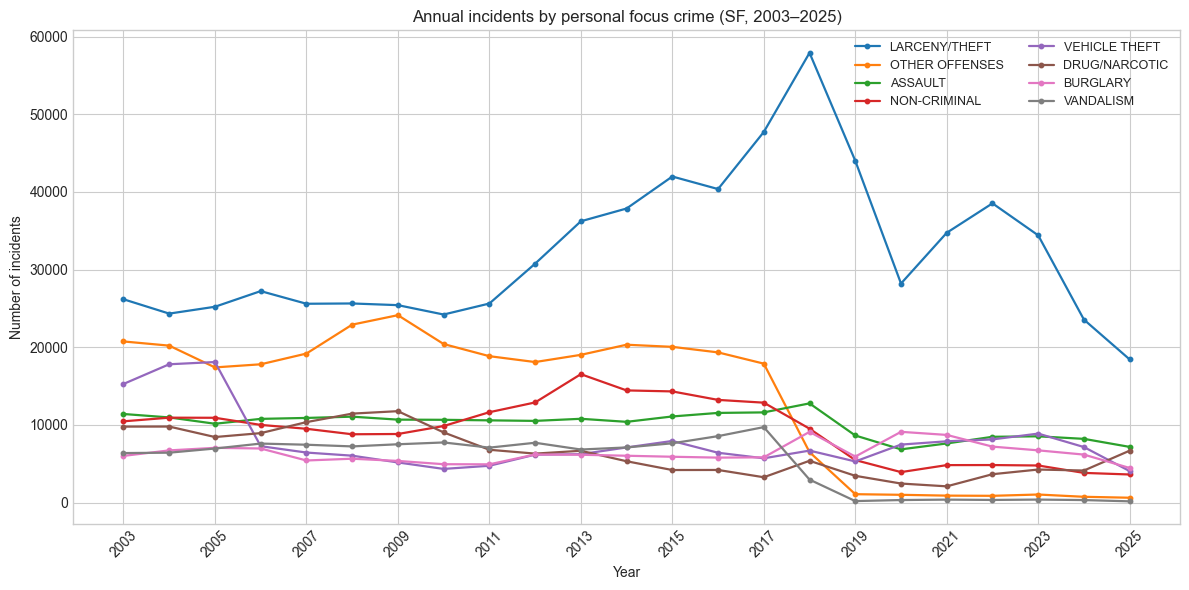

In [2]:
# Assignment 1.1 — Temporal overview (incidents per year)
yearly = (
    focus.groupby(["year", "crime"]) 
         .size()
         .rename("incidents")
         .reset_index()
)

year_range = np.arange(2003, 2026)

fig, ax = plt.subplots(figsize=(12, 6))
for crime in PERSONAL_FOCUS_CRIMES:
    series = (
        yearly[yearly["crime"] == crime]
        .set_index("year")["incidents"]
        .reindex(year_range, fill_value=0)
    )
    ax.plot(year_range, series.values, marker='o', linewidth=1.6, markersize=3.2, label=crime)

ax.set_title("Annual incidents by personal focus crime (SF, 2003–2025)")
ax.set_xlabel("Year")
ax.set_ylabel("Number of incidents")
ax.legend(loc='upper right', ncol=2, fontsize=9)
ax.set_xticks(np.arange(2003, 2026, 2))
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

- We observe a clear COVID-era drop in `LARCENY/THEFT` around 2020, likely linked to lockdowns, reduced tourism, and lower street activity.
- Before 2020, `LARCENY/THEFT` shows a long upward trend, suggesting increasing concentration of incidents in dense commercial/visitor areas.
- After the COVID dip, levels recover partly but do not immediately return to the 2017–2018 peak, indicating a structural shift in mobility and routine activity patterns.

---
## Assignment 1.2: Crime Profiles by Police District

Different parts of the city have very different crime patterns. Here we quantify that using conditional probabilities.

*Draws from*: Week 3, Exercises 2.1 and 2.2.

> * For each police district in your dataset, compute the **conditional crime profile**: for each of your Personal Focus Crimes, calculate
>
>   $$r(\text{crime}, \text{district}) = \frac{P(\text{crime} \mid \text{district})}{P(\text{crime})}$$
>
>   A value above 1 means that crime type is *over-represented* in that district relative to the city-wide average; below 1 means it is *under-represented*.
> * Visualize these ratios in a way that makes it easy to compare across both districts and crime types. (Simple barcharts are fine, but you may also use ideas from more complex visualization techniques, for example, a heatmap could work well here, but you're free to choose another format if you can justify it.)
> * Pick **one district** whose profile stands out to you. Describe the pattern and offer an explanation for why that district looks the way it does. Are there geographic, demographic, or other factors that might explain it?

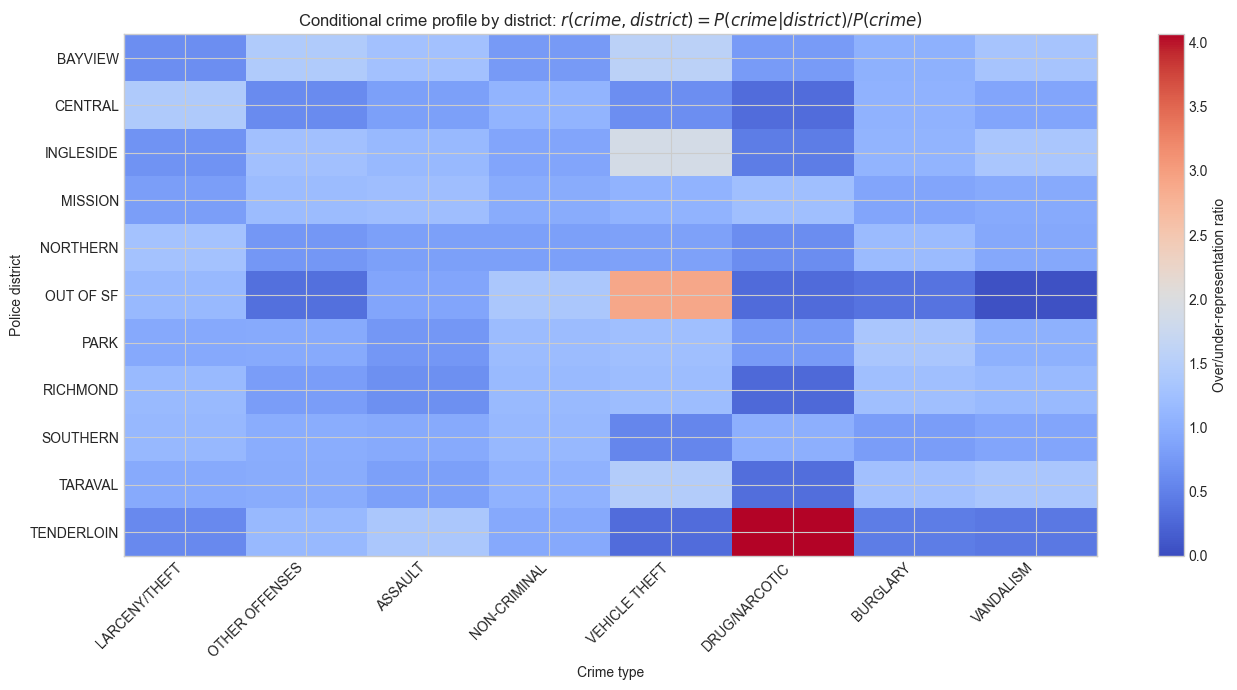

crime,LARCENY/THEFT,OTHER OFFENSES,ASSAULT,NON-CRIMINAL,VEHICLE THEFT,DRUG/NARCOTIC,BURGLARY,VANDALISM
district,,,,,,,,
BAYVIEW,0.64,1.44,1.28,0.78,1.57,0.78,1.04,1.33
CENTRAL,1.41,0.61,0.83,1.10,0.65,0.31,1.05,0.90
INGLESIDE,0.69,1.26,1.15,0.89,1.89,0.46,1.09,1.36
MISSION,0.82,1.21,1.22,0.97,1.07,1.24,0.89,0.95
NORTHERN,1.30,0.74,0.83,0.83,0.85,0.63,1.18,0.93
OUT OF SF,1.15,0.34,0.89,1.38,2.89,0.29,0.37,0.05
PARK,0.95,0.96,0.75,1.19,1.25,0.78,1.35,1.04
RICHMOND,1.16,0.80,0.65,1.17,1.22,0.28,1.24,1.16
SOUTHERN,1.14,0.99,0.96,1.14,0.56,1.02,0.80,0.89


In [3]:
# Assignment 1.2 — Conditional crime profile by district
city_p = focus["crime"].value_counts(normalize=True)
district_crime = (
    focus.groupby(["district", "crime"]) 
         .size()
         .rename("count")
         .reset_index()
)
district_totals = district_crime.groupby("district")["count"].transform("sum")
district_crime["p_crime_given_district"] = district_crime["count"] / district_totals
district_crime["p_crime_city"] = district_crime["crime"].map(city_p)
district_crime["ratio"] = district_crime["p_crime_given_district"] / district_crime["p_crime_city"]

ratio_matrix = (
    district_crime.pivot(index="district", columns="crime", values="ratio")
    .reindex(columns=PERSONAL_FOCUS_CRIMES)
    .fillna(0)
)

fig, ax = plt.subplots(figsize=(1.2 * len(PERSONAL_FOCUS_CRIMES) + 4, 7))
im = ax.imshow(ratio_matrix.values, aspect='auto', cmap='coolwarm', vmin=0, vmax=max(2.5, np.nanmax(ratio_matrix.values)))

ax.set_title(r"Conditional crime profile by district: $r(crime,district)=P(crime|district)/P(crime)$")
ax.set_xlabel("Crime type")
ax.set_ylabel("Police district")
ax.set_xticks(range(len(ratio_matrix.columns)))
ax.set_xticklabels(ratio_matrix.columns, rotation=45, ha='right')
ax.set_yticks(range(len(ratio_matrix.index)))
ax.set_yticklabels(ratio_matrix.index)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Over/under-representation ratio")
plt.tight_layout()
plt.show()

ratio_matrix.round(2)


- `DRUG/NARCOTIC` is strongly over-represented in Tenderloin (highest ratio relative to city average).
- A plausible explanation is dense street activity, concentration of social services, and policing/reporting focus in that area.
- `OUT OF SF` also stands out for some categories, but it should be interpreted cautiously since it is an administrative catch-all category, not a normal neighborhood district.

---
## Assignment 1.3: Visualizing Distributions

This exercise asks you to recreate several classic plot types from DAOST Chapter 2 using your own crime data — putting visualization theory into practice.

*Draws from*: Week 3, Exercises 5.2 and 5.3.

> **Part A — Jitter plot**
> * Pick one of your Personal Focus Crimes and a suitable time interval (somewhere between a month and 6 months, depending on how common the crime is). Create a jitter plot of the incident times during a single hour (e.g. 13:00–14:00): let time run along the $x$-axis and add vertical jitter.
> * What does the jitter plot reveal about how times are recorded in the dataset? Are incidents clustered at certain minutes (on the hour, half hour, etc.)? What does this tell you about the precision of the data?
>
> **Part B — Probability plot**
> * Using the same geographic data from Part B, create a probability plot (QQ plot) for the latitude distribution of each of your two crime types. (`scipy.stats.probplot` is your friend here.)
> * What reference distribution are you comparing against? What would it mean if the points fell exactly on the straight line? Where does the distribution deviate from normal, and what does that deviation tell you about the geography of crime in SF?
>
> **Part C — Box plots of time-of-day**
> * For each of your Personal Focus Crimes, extract the time-of-day of every incident.
> * Create box plots showing the time-of-day distribution for all your Personal Focus Crimes side by side.
> * What patterns do you see? Are there crimes that happen mostly at night? Mostly during business hours? For crimes that peak late at night, does the box plot handle the wrap-around at midnight well? What goes wrong?
> * Above, feel free to use alternatives to box plots — violin plots, swarm plots, or raincloud plots — if you think they reveal more. If you do, briefly explain what the alternative shows that the box plot doesn't.

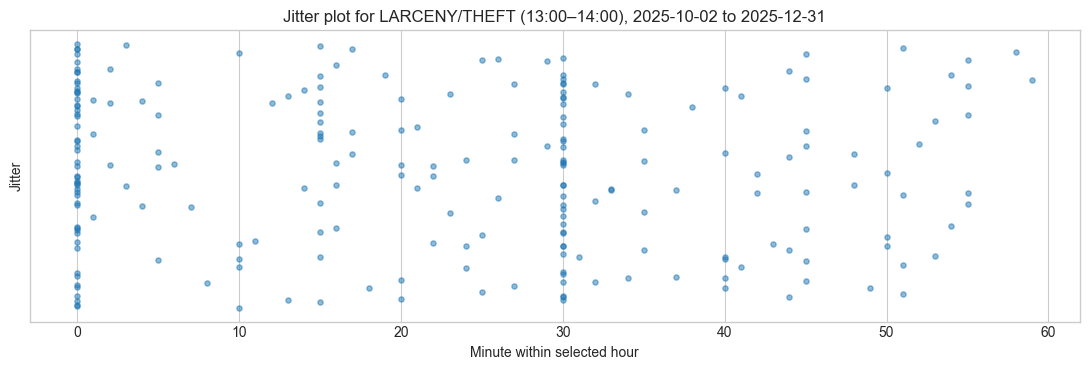

minute
0     52
1      3
2      3
3      2
4      2
5      5
6      1
7      1
8      1
10     5
11     1
12     1
13     2
14     2
15    13
16     4
17     3
18     1
19     1
20     6
Name: count, dtype: int64

In [4]:
# Assignment 1.3A — Jitter plot of incident times within one hour
jitter_crime = PERSONAL_FOCUS_CRIMES[0]

# Use a 3-month window ending at latest date in focus data
end_date = focus["dt"].max()
start_date = end_date - pd.Timedelta(days=90)
window = focus[(focus["crime"] == jitter_crime) & (focus["dt"].between(start_date, end_date))].copy()

target_hour = 13
window_hour = window[window["hour"] == target_hour].copy()
window_hour["minute_fraction"] = window_hour["minute"] + window_hour["dt"].dt.second / 60.0

y_jitter = np.random.uniform(-0.4, 0.4, size=len(window_hour))

fig, ax = plt.subplots(figsize=(11, 3.8))
ax.scatter(window_hour["minute_fraction"], y_jitter, alpha=0.5, s=14)
ax.set_title(f"Jitter plot for {jitter_crime} ({target_hour:02d}:00–{target_hour+1:02d}:00), {start_date.date()} to {end_date.date()}")
ax.set_xlabel("Minute within selected hour")
ax.set_ylabel("Jitter")
ax.set_yticks([])
plt.tight_layout()
plt.show()

# Inspect minute spikes directly
window_hour["minute"].value_counts().sort_index().head(20)

- The jitter plot shows clear minute-level clustering (especially at `00` and `30`), so timestamps are not uniformly precise.
- This suggests many incidents are recorded with rounded or estimated times rather than exact event times.
- We therefore interpret fine-grained minute patterns cautiously and focus more on broader hourly trends.

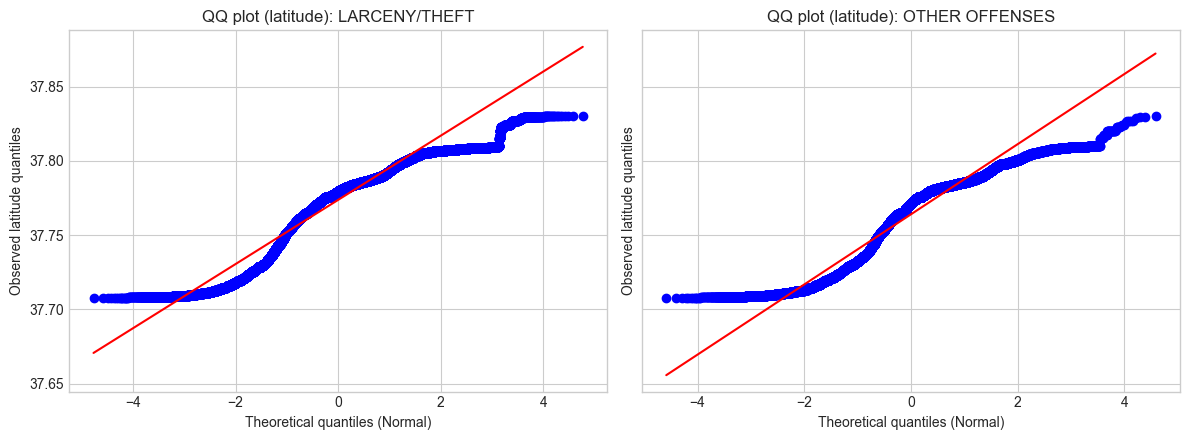

In [5]:
# Assignment 1.3B — QQ (probability) plots for latitude distributions
if len(PERSONAL_FOCUS_CRIMES) < 2:
    raise ValueError("Need at least 2 focus crimes for Part B.")

qq_crimes = PERSONAL_FOCUS_CRIMES[:2]
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharey=True)

for ax, crime in zip(axes, qq_crimes):
    lat_values = focus.loc[focus["crime"] == crime, "lat"].dropna().values
    stats.probplot(lat_values, dist="norm", plot=ax)
    ax.set_title(f"QQ plot (latitude): {crime}")
    ax.set_xlabel("Theoretical quantiles (Normal)")
    ax.set_ylabel("Observed latitude quantiles")

plt.tight_layout()
plt.show()

- The QQ plots compare observed latitude quantiles with a Normal reference distribution.
- If points followed the line exactly, latitude would be approximately normal; instead we see systematic curvature and tail deviations.
- This indicates spatial clustering and bounded geography in SF, not a single symmetric spatial spread.

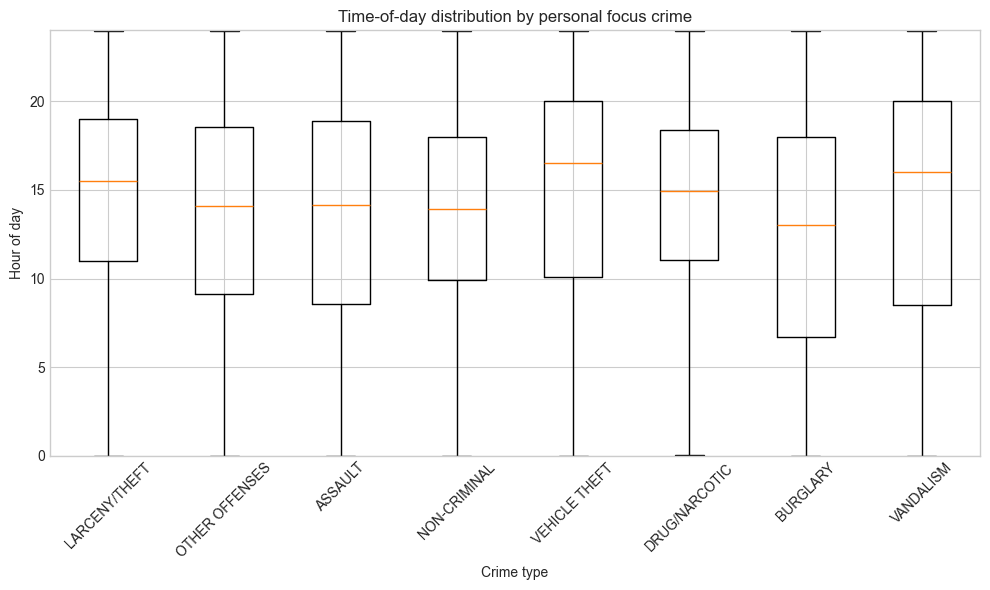

In [6]:
# Assignment 1.3C — Box plots of time-of-day by crime
time_distributions = [
    focus.loc[focus["crime"] == crime, "time_of_day"].dropna().values
    for crime in PERSONAL_FOCUS_CRIMES
]

fig, ax = plt.subplots(figsize=(max(10, len(PERSONAL_FOCUS_CRIMES) * 1.2), 6))
ax.boxplot(time_distributions, labels=PERSONAL_FOCUS_CRIMES, showfliers=False)
ax.set_title("Time-of-day distribution by personal focus crime")
ax.set_xlabel("Crime type")
ax.set_ylabel("Hour of day")
ax.set_ylim(0, 24)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

- Time-of-day patterns differ across crimes: some categories center around daytime/afternoon, while others are more evening-leaning. Like we can see that `VEHICLE THEFT` and `VANDLISM` leans more towards later in the day
- Box plots summarize central tendency and spread well, but they do not handle circular time perfectly.
- For late-night behavior, values near `23:xx` and `00:xx` are plotted far apart, which can hide true continuity around midnight.

---
## Assignment 1.4: Spatial Power Law

Is crime spread evenly across San Francisco, or is it concentrated in a small number of hotspots? Let's find out.

*Draws from*: Week 4, Exercise 2.2.

Use your **most common Personal Focus Crime** (by total incident count) for this exercise.

> * **Step 1**: Divide San Francisco into a grid of approximately $100\text{m} \times 100\text{m}$ cells using latitude and longitude. It is fine to ignore that the Earth isn't flat — the approximation is good enough for this purpose.
>     * **Hint**: `np.histogram2d` works well here. Focus on points within the SF peninsula; filter out geographic outliers.
> * **Step 2**: Count the number of incidents of your chosen crime in each grid cell (use all years of data).
> * **Step 3**: Tally the distribution. Count how many cells have exactly $k$ incidents — call this $N(k)$ — for $k = 0, 1, 2, \ldots$ up to the maximum.
> * **Step 4**: Plot $(k+1)$ vs $N(k)$ on **linear axes**.
> * **Step 5**: Plot $(k+1)$ vs $N(k)$ on **loglog axes**.
> * **Step 6**: Does your crime follow a power-law spatial distribution? How can you tell from the loglog plot?
> * **Step 7**: If crime is spatially concentrated in a small number of cells, what does that imply for how we interpret neighborhood-level crime statistics? Does the "average block" tell you anything useful?

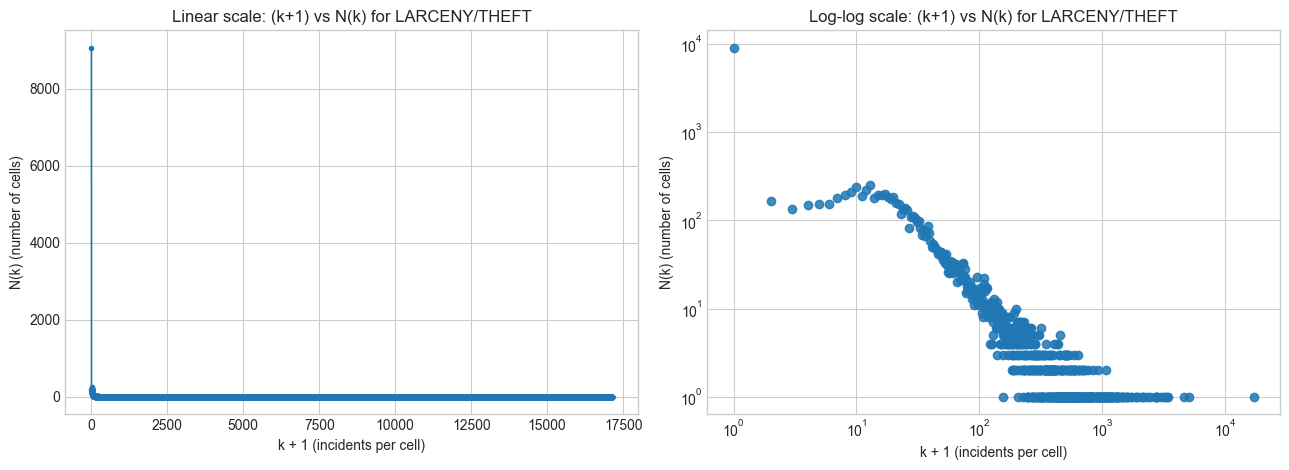

Selected crime: LARCENY/THEFT
Grid cells: 17,816
Non-empty cells: 8,759


In [7]:
# Assignment 1.4 — Spatial power law (100m x 100m grid)
most_common_focus_crime = focus["crime"].value_counts().idxmax()
crime_points = focus[focus["crime"] == most_common_focus_crime].copy()

# Approximate SF peninsula bounding box to remove outliers
crime_points = crime_points[
    (crime_points["lat"].between(37.70, 37.84)) &
    (crime_points["lon"].between(-122.53, -122.35))
].copy()

mean_lat = crime_points["lat"].mean()
lat_step = 100 / 111_000
lon_step = 100 / (111_000 * np.cos(np.deg2rad(mean_lat)))

lat_edges = np.arange(crime_points["lat"].min(), crime_points["lat"].max() + lat_step, lat_step)
lon_edges = np.arange(crime_points["lon"].min(), crime_points["lon"].max() + lon_step, lon_step)

H, _, _ = np.histogram2d(crime_points["lat"], crime_points["lon"], bins=[lat_edges, lon_edges])
cell_counts = H.astype(int).ravel()

Nk = np.bincount(cell_counts)
k_vals = np.arange(len(Nk))

fig, axes = plt.subplots(1, 2, figsize=(13, 4.8))

axes[0].plot(k_vals + 1, Nk, marker='o', linewidth=1.2, markersize=3)
axes[0].set_title(f"Linear scale: (k+1) vs N(k) for {most_common_focus_crime}")
axes[0].set_xlabel("k + 1 (incidents per cell)")
axes[0].set_ylabel("N(k) (number of cells)")

valid = (Nk > 0)
axes[1].loglog((k_vals[valid] + 1), Nk[valid], marker='o', linestyle='none', alpha=0.85)
axes[1].set_title(f"Log-log scale: (k+1) vs N(k) for {most_common_focus_crime}")
axes[1].set_xlabel("k + 1 (incidents per cell)")
axes[1].set_ylabel("N(k) (number of cells)")

plt.tight_layout()
plt.show()

print(f"Selected crime: {most_common_focus_crime}")
print(f"Grid cells: {cell_counts.size:,}")
print(f"Non-empty cells: {(cell_counts > 0).sum():,}")

- The log-log plot shows a long right tail: many cells have few incidents, while a small number of cells have very high counts.
- This is consistent with a power-law-like concentration pattern (approximately linear over part of the log-log range).
- Therefore, crime is highly spatially concentrated, and neighborhood averages can hide strong micro-hotspot structure.

---
## Assignment 1.5: Regression and Correlation

Which of your Personal Focus Crimes share the most similar weekly rhythm — and which are completely out of sync?

*Draws from*: Week 4, Exercises 3.1, 3.2, and 3.3.

Select **at least 4** of your Personal Focus Crimes for this exercise. More is fine - if you want to be closer to the actual weekly exercise.

> * For each selected crime type, compute the total number of incidents for each of the **168 hours of the week** (i.e., Monday 00:00–01:00, Monday 01:00–02:00, ..., Sunday 23:00–00:00). Each crime type will give you a vector of 168 values.
>
> * **Scatterplot matrix**: Create a grid of pairwise scatterplots — one panel per pair of crime types, with one crime on each axis and each of the 168 hours as a point. Label each panel clearly with the two crime types being compared.
>
> * **Linear regression**: Using the closed-form equations from Week 4 (not a library), fit a regression line $y = ax + b$ to each pair and add it to the relevant panel:
>   $$a = \frac{\sum_i x_i y_i - N\langle x\rangle\langle y\rangle}{\sum_i x_i^2 - N\langle x\rangle^2}, \qquad b = \langle y \rangle - a\langle x \rangle$$
>
> * **$R^2$**: Compute $R^2$ for each pair and display the value on each panel. 
>
> * Looking at your results: which pair of crimes is **most correlated**? Which is **least correlated**? Does the answer match your intuition? Why might two crime types share a weekly rhythm — or not?

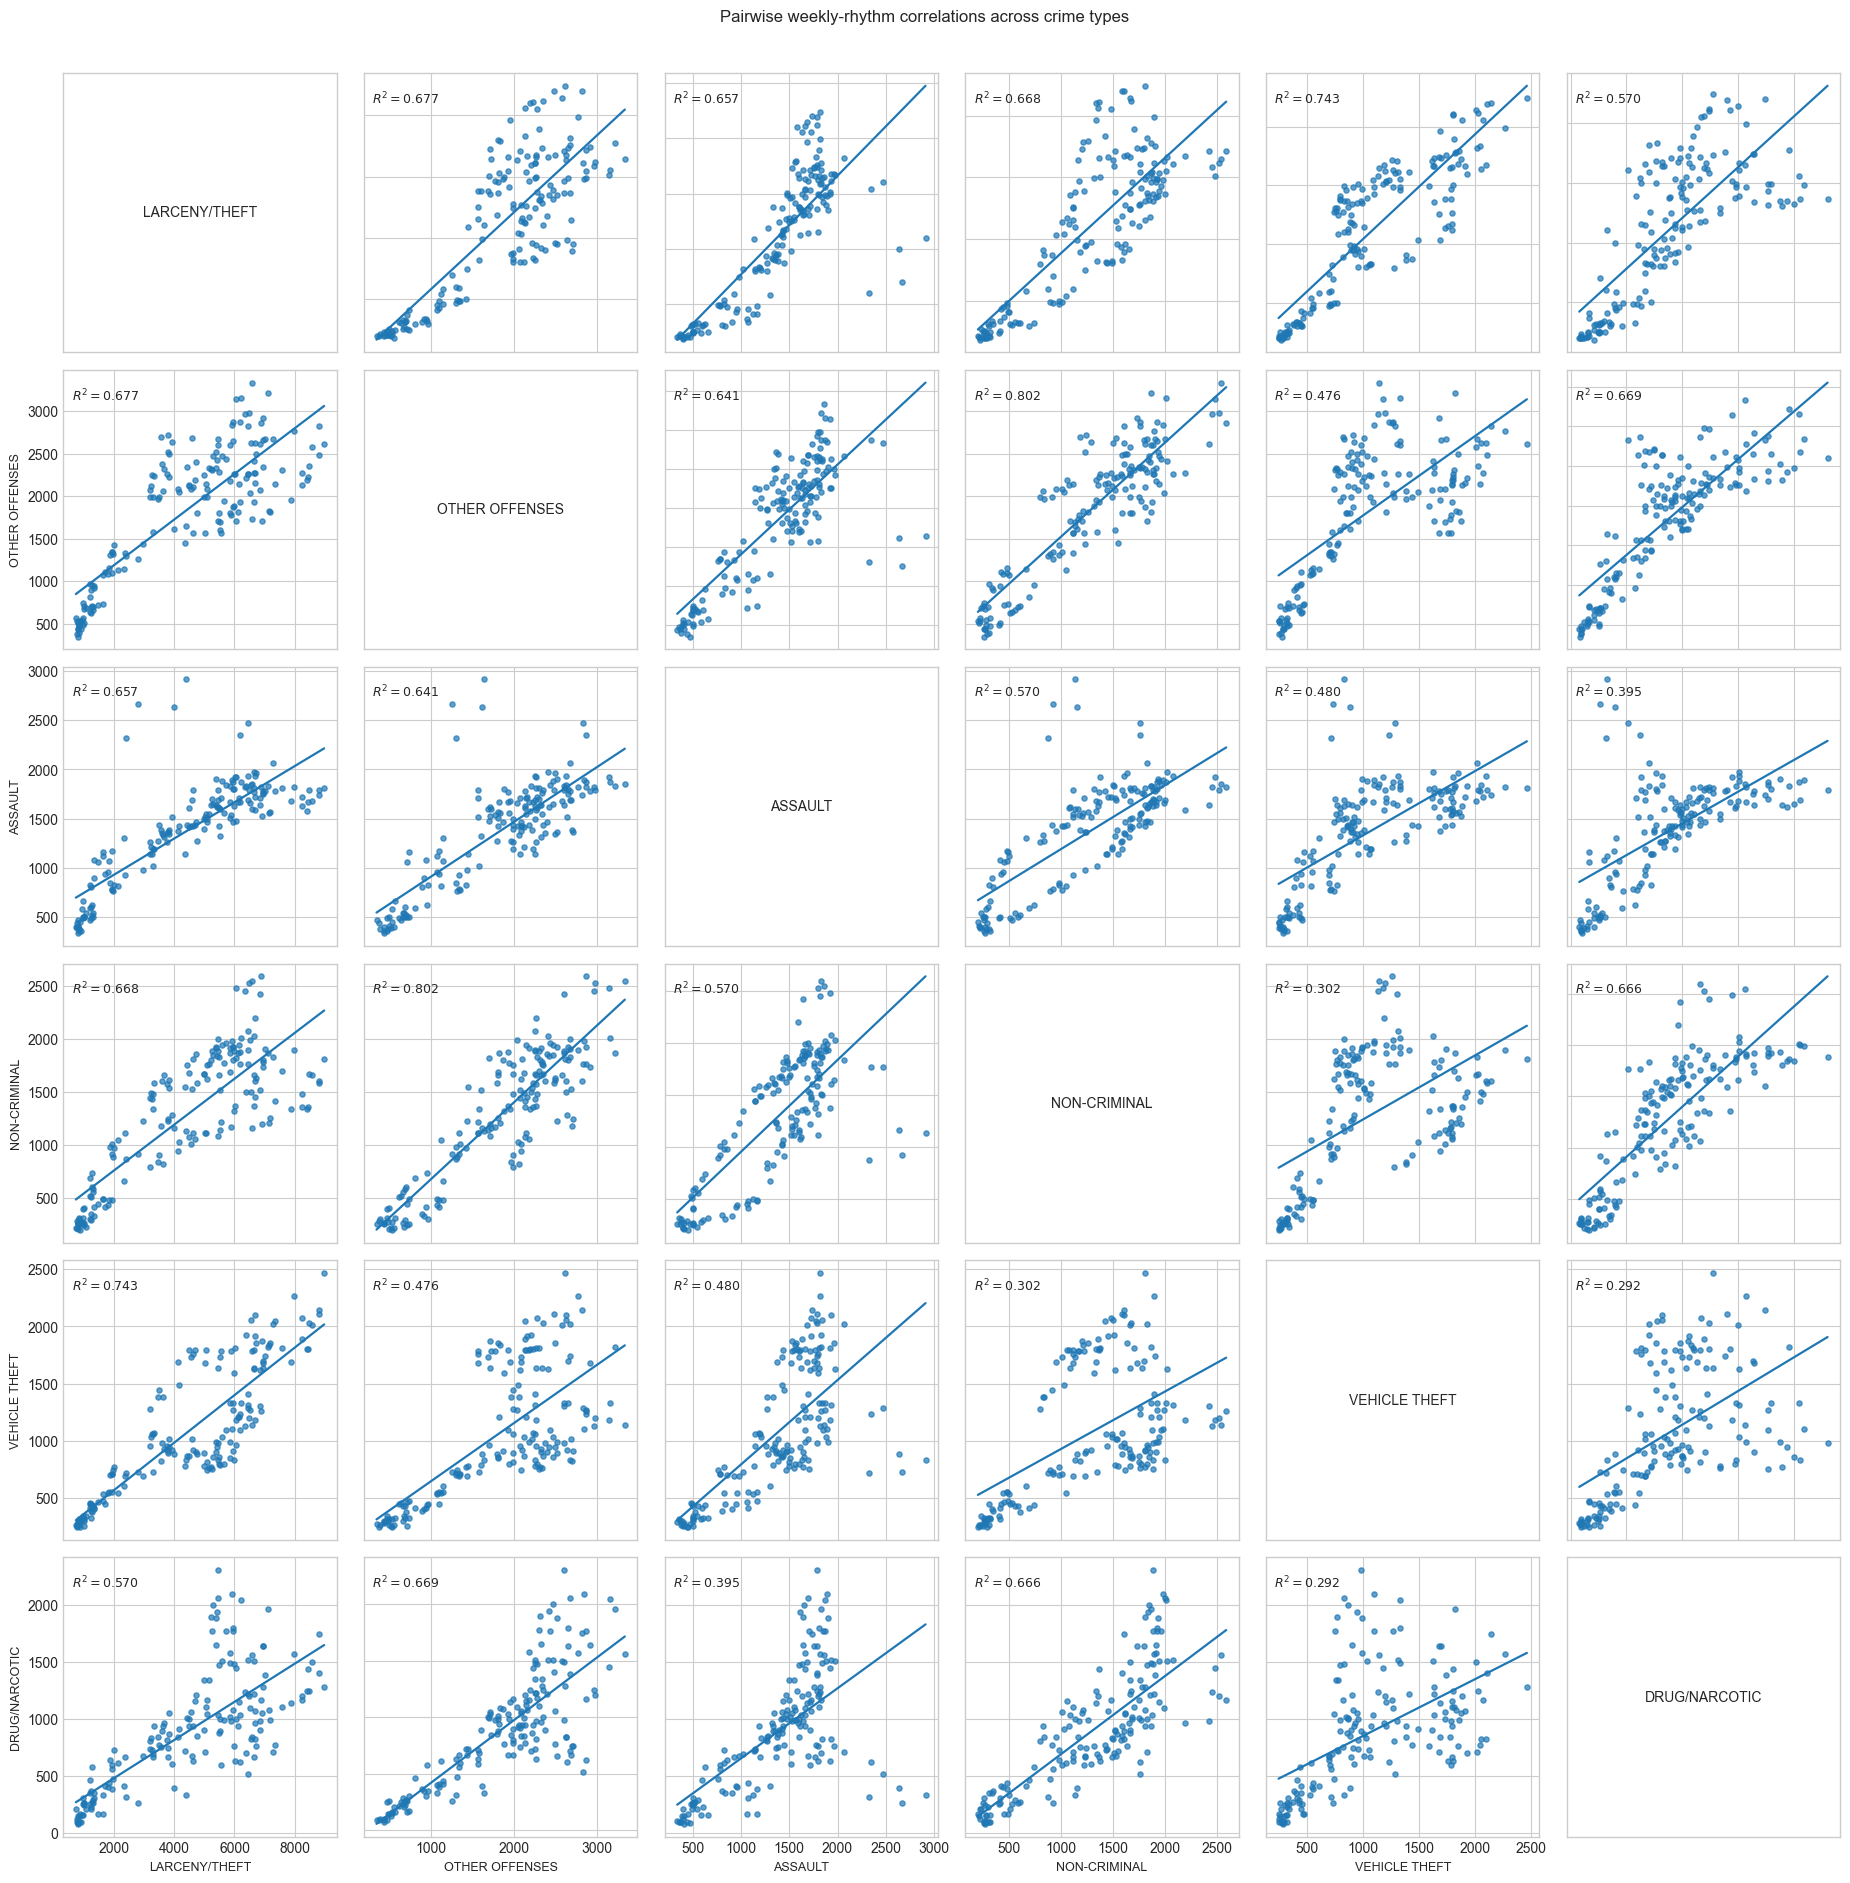

Most correlated pair: ('NON-CRIMINAL', 'OTHER OFFENSES') with R^2=0.802
Least correlated pair: ('DRUG/NARCOTIC', 'VEHICLE THEFT') with R^2=0.292


,pair,r2
12,"(NON-CRIMINAL, OTHER OFFENSES)",0.801705
11,"(LARCENY/THEFT, VEHICLE THEFT)",0.742552
10,"(LARCENY/THEFT, OTHER OFFENSES)",0.677022
7,"(DRUG/NARCOTIC, OTHER OFFENSES)",0.668922
9,"(LARCENY/THEFT, NON-CRIMINAL)",0.668034
6,"(DRUG/NARCOTIC, NON-CRIMINAL)",0.665731
1,"(ASSAULT, LARCENY/THEFT)",0.656732
3,"(ASSAULT, OTHER OFFENSES)",0.641431
2,"(ASSAULT, NON-CRIMINAL)",0.570315
5,"(DRUG/NARCOTIC, LARCENY/THEFT)",0.569914


In [8]:
# Assignment 1.5 — Scatterplot matrix + closed-form regression + R^2
selected_for_regression = PERSONAL_FOCUS_CRIMES[:max(4, min(len(PERSONAL_FOCUS_CRIMES), 6))]
if len(selected_for_regression) < 4:
    raise ValueError("Select at least 4 focus crimes for Assignment 1.5.")

weekly_vectors = {}
for crime in selected_for_regression:
    vec = (
        focus[focus["crime"] == crime]
        .groupby("weekhour")
        .size()
        .reindex(np.arange(168), fill_value=0)
        .to_numpy(dtype=float)
    )
    weekly_vectors[crime] = vec


def closed_form_regression(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    N = len(x)
    x_mean = x.mean()
    y_mean = y.mean()
    numerator = (x * y).sum() - N * x_mean * y_mean
    denominator = (x * x).sum() - N * (x_mean ** 2)
    if np.isclose(denominator, 0):
        a = 0.0
    else:
        a = numerator / denominator
    b = y_mean - a * x_mean

    y_hat = a * x + b
    ss_res = ((y - y_hat) ** 2).sum()
    ss_tot = ((y - y_mean) ** 2).sum()
    r2 = 1 - ss_res / ss_tot if not np.isclose(ss_tot, 0) else np.nan
    return a, b, r2


crimes = selected_for_regression
m = len(crimes)
fig, axes = plt.subplots(m, m, figsize=(3.1 * m, 3.1 * m))

r2_table = pd.DataFrame(np.nan, index=crimes, columns=crimes)

for i, cy in enumerate(crimes):
    for j, cx in enumerate(crimes):
        ax = axes[i, j]
        x = weekly_vectors[cx]
        y = weekly_vectors[cy]

        if i == j:
            ax.text(0.5, 0.5, cx, ha='center', va='center', fontsize=10, transform=ax.transAxes)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        ax.scatter(x, y, s=14, alpha=0.7)
        a, b, r2 = closed_form_regression(x, y)
        x_line = np.linspace(x.min(), x.max(), 100)
        ax.plot(x_line, a * x_line + b, linewidth=1.6)
        ax.text(0.03, 0.94, f"$R^2={r2:.3f}$", transform=ax.transAxes, va='top', fontsize=9)
        r2_table.loc[cy, cx] = r2

        if i == m - 1:
            ax.set_xlabel(cx, fontsize=9)
        else:
            ax.set_xticklabels([])

        if j == 0:
            ax.set_ylabel(cy, fontsize=9)
        else:
            ax.set_yticklabels([])

fig.suptitle("Pairwise weekly-rhythm correlations across crime types", y=1.01)
plt.tight_layout()
plt.show()

# Identify strongest/weakest pair (excluding diagonal)
stacked = r2_table.stack().reset_index()
stacked.columns = ["crime_y", "crime_x", "r2"]
stacked = stacked[stacked["crime_x"] != stacked["crime_y"]].copy()
stacked["pair"] = stacked.apply(lambda r: tuple(sorted([r["crime_x"], r["crime_y"]])), axis=1)
unique_pairs = stacked.groupby("pair", as_index=False)["r2"].mean()

best_pair = unique_pairs.loc[unique_pairs["r2"].idxmax()]
worst_pair = unique_pairs.loc[unique_pairs["r2"].idxmin()]

print("Most correlated pair:", best_pair["pair"], f"with R^2={best_pair['r2']:.3f}")
print("Least correlated pair:", worst_pair["pair"], f"with R^2={worst_pair['r2']:.3f}")
unique_pairs.sort_values("r2", ascending=False).head(10)

- The strongest weekly-rhythm correlation is between `NON-CRIMINAL` and `OTHER OFFENSES` (high $R^2$), meaning they co-vary similarly across the 168 weekly hours.
- The weakest pair is `DRUG/NARCOTIC` vs `VEHICLE THEFT` (low $R^2$), indicating distinct temporal dynamics.
- This is plausible: some crimes are tied to shared routine activity cycles, while others are driven by different contexts and enforcement patterns.

## Contributions

- Member 1: s205835 Vaneeza Fatima Butt — 1.1, 1.3A, 1.3B, 1.4
- Member 2: s204465 Muhammad Numan Bashir — 1.2, 1.3C, 1.5

All group members discussed the interpretation and final write-up together.